In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

df= pd.read_csv("../data/raw/ecommerce_clickstream_transactions.csv")
df.head()

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome
0,1,1,2024-07-07 18:00:26.959902,page_view,NaN,NaN,NaN
1,1,1,2024-03-05 22:01:00.072000,page_view,NaN,NaN,NaN
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,NaN
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,NaN
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,NaN


In [3]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74817 entries, 0 to 74816
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   UserID     74817 non-null  int64  
 1   SessionID  74817 non-null  int64  
 2   Timestamp  74817 non-null  object 
 3   EventType  74817 non-null  object 
 4   ProductID  32113 non-null  object 
 5   Amount     10682 non-null  float64
 6   Outcome    10682 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 4.0+ MB


(74817, 7)

In [4]:
df["EventType"].value_counts()

EventType
page_view       10819
add_to_cart     10735
product_view    10696
logout          10685
purchase        10682
click           10632
login           10568
Name: count, dtype: int64

In [5]:
# Filter funnel events only
funnel_events = df[df["EventType"].isin(["page_view", "product_view","add_to_cart", "purchase"])]
funnel_events.head()


,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome
0,1,1,2024-07-07 18:00:26.959902,page_view,NaN,NaN,NaN
1,1,1,2024-03-05 22:01:00.072000,page_view,NaN,NaN,NaN
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,NaN
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,NaN
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,NaN


In [6]:
funnel_events.shape

(42932, 7)

In [7]:
df = df.dropna(subset=["UserID"])

In [8]:
funnel_events.head()

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome
0,1,1,2024-07-07 18:00:26.959902,page_view,NaN,NaN,NaN
1,1,1,2024-03-05 22:01:00.072000,page_view,NaN,NaN,NaN
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,NaN
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,NaN
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,NaN


In [12]:
funnel_events.to_csv("../data/cleaned/ecommerce_clickstream_cleaned.csv", index=False)

In [10]:
# One Funnel pass per UserID

funnel =(
    funnel_events
    .groupby("UserID")["EventType"]
    .unique()
    .reset_index()
)
# Create boolean indicator columns for each step in the funnel.
# Each column checks whether the EventType string contains a specific action.
# This allows us to track how users move through the funnel: 
# page_view → product_view → add_to_cart → purchase.
funnel.head()

,UserID,EventType
0,1,"[page_view, product_view, add_to_cart, purchase]"
1,2,"[page_view, purchase, add_to_cart, product_view]"
2,3,"[add_to_cart, purchase, page_view, product_view]"
3,4,"[purchase, page_view, add_to_cart, product_view]"
4,5,"[add_to_cart, page_view, product_view, purchase]"


In [11]:
# Create boolean indicator columns for each step in the funnel.
# Each column checks whether the EventType string contains a specific action.
# This allows us to track how users move through the funnel: 
# page_view → product_view → add_to_cart → purchase.


# Create a boolean column indicating whether the event is a page view
funnel['page_view'] = funnel['EventType'].apply(lambda x: 'page_view' in x)

# Create a boolean column indicating whether the event is a product view
funnel['product_view'] = funnel['EventType'].apply(lambda x: 'product_view' in x)

# Create a boolean column indicating whether the event is an add-to-cart action
funnel['add_to_cart'] = funnel['EventType'].apply(lambda x: 'add_to_cart' in x)

# Create a boolean column indicating whether the event is a purchase
funnel['purchase'] = funnel['EventType'].apply(lambda x: 'purchase' in x)

In [12]:
funnel.head()

,UserID,EventType,page_view,product_view,add_to_cart,purchase
0,1,"[page_view, product_view, add_to_cart, purchase]",True,True,True,True
1,2,"[page_view, purchase, add_to_cart, product_view]",True,True,True,True
2,3,"[add_to_cart, purchase, page_view, product_view]",True,True,True,True
3,4,"[purchase, page_view, add_to_cart, product_view]",True,True,True,True
4,5,"[add_to_cart, page_view, product_view, purchase]",True,True,True,True


In [13]:
# Create a summary table showing how many users reached each step of the funnel.
# Each value is calculated by summing the boolean indicator columns created earlier.
# This structure makes it easy to analyze drop-off between steps and calculate
# conversion rates throughout the customer journey.


funnel_counts = pd.DataFrame({
    
    # Names of the funnel steps in order
    'step': ['Page View', 'Product View', 'Add to Cart', 'Purchase'],
    
    # Count of users/events for each step, computed by summing the boolean columns
    'users': [
        funnel['page_view'].sum(),        # Total number of page views
        funnel['product_view'].sum(),     # Total number of product views
        funnel['add_to_cart'].sum(),      # Total number of add-to-cart events
        funnel['purchase'].sum()          # Total number of purchases
    ]
})

funnel_counts

,step,users
0,Page View,1000
1,Product View,1000
2,Add to Cart,1000
3,Purchase,1000


In [14]:
funnel_counts['conversion_rate'] = (
    funnel_counts['users'] / funnel_counts['users'].shift(1)
)

funnel_counts['drop_off_rate'] = 1 - funnel_counts['conversion_rate']
funnel_counts


,step,users,conversion_rate,drop_off_rate
0,Page View,1000,NaN,NaN
1,Product View,1000,1.0,0.0
2,Add to Cart,1000,1.0,0.0
3,Purchase,1000,1.0,0.0


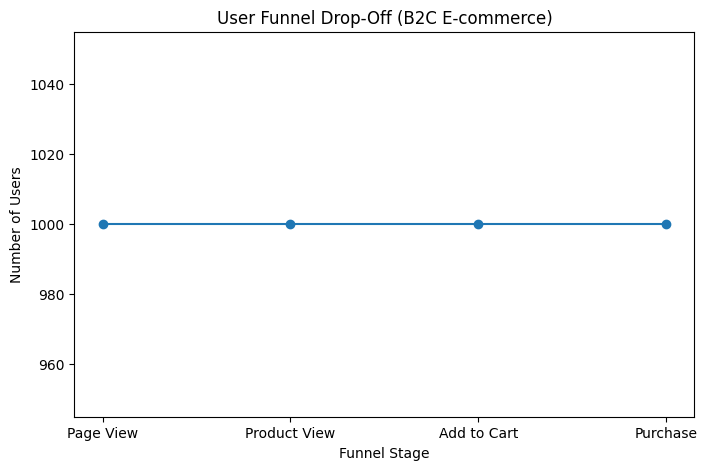

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(funnel_counts['step'], funnel_counts['users'], marker='o')
plt.title('User Funnel Drop-Off (B2C E-commerce)')
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Users')
plt.show()

In [16]:
df = df.sort_values(['UserID', 'Timestamp'])
df.head()
df.shape

(74817, 7)

In [17]:
# Define the funnel steps in order
steps = ['page_view', 'product_view', 'add_to_cart', 'purchase']

# Build a table showing the FIRST time each user performed each funnel step

user_steps = (
    df[df['EventType'].isin(steps)]     # 1. Keep only funnel events
    .groupby(['UserID', 'EventType'])['Timestamp']   # 2. Group by user and event type
    .min()
    .unstack()
)

# Display the resulting user-level funnel table
user_steps.head()

EventType,add_to_cart,page_view,product_view,purchase
UserID,,,,
1,2024-01-02 00:15:51.420238,2024-01-01 23:09:51.956825,2024-01-13 19:09:28.166082,2024-01-19 16:51:29.413903
2,2024-01-01 14:07:40.491141,2024-01-25 23:29:19.998646,2024-02-01 13:04:02.540578,2024-01-07 08:29:00.313651
3,2024-01-28 23:19:16.739808,2024-02-14 10:49:22.406027,2024-01-28 04:05:50.814865,2024-01-23 18:04:26.951982
4,2024-01-18 16:10:27.101290,2024-01-01 02:11:06.298369,2024-01-28 09:19:43.994239,2024-02-04 10:29:30.492336
5,2024-01-29 10:06:50.111563,2024-01-05 11:02:48.872797,2024-01-01 14:03:07.709158,2024-01-15 09:52:49.801700


In [18]:
# Create a new DataFrame with the same users as index
funnel_users = pd.DataFrame(index=user_steps.index)

funnel_users['page_view'] = user_steps['page_view'].notna()

# A user reaches 'product_view' only if:
# 1. They reached the previous step (page_view)
# 2. They actually have a product_view timestamp
# 3. The product_view happened AFTER the page_view

funnel_users['product_view'] = (
    funnel_users['page_view'] &
    user_steps['product_view'].notna() &
    (user_steps['product_view'] > user_steps['page_view'])
)

funnel_users['add_to_cart'] = (
    funnel_users['product_view'] &
    user_steps['add_to_cart'].notna() &
    (user_steps['add_to_cart'] > user_steps['product_view'])
)

funnel_users['purchase'] = (
    funnel_users['add_to_cart'] &
    user_steps['purchase'].notna() &
    (user_steps['purchase'] > user_steps['add_to_cart'])
)

funnel_users.head()

,page_view,product_view,add_to_cart,purchase
UserID,,,,
1,True,True,False,False
2,True,True,False,False
3,True,False,False,False
4,True,True,False,False
5,True,False,False,False


In [19]:
# Create a summary table for the funnel
funnel_counts1 = pd.DataFrame({
     # Names of the funnel steps
    'step': ['Page View', 'Product View', 'Add to Cart', 'Purchase'],

    # Count how many users reached each step
    # Each column in funnel_users is True/False, so .sum() counts the Trues
    'users': [
        funnel_users['page_view'].sum(),
        funnel_users['product_view'].sum(),
        funnel_users['add_to_cart'].sum(),
        funnel_users['purchase'].sum()
    ]
})

# Calculate conversion rate from the previous step
# users.shift(1) aligns each step with the previous step's user count
funnel_counts1['conversion_rate'] = (
    funnel_counts1['users'] / funnel_counts1['users'].shift(1)
)
# Drop-off rate is simply the inverse of conversion
funnel_counts1['drop_off_rate'] = 1 - funnel_counts1['conversion_rate']

funnel_counts1  


,step,users,conversion_rate,drop_off_rate
0,Page View,1000,NaN,NaN
1,Product View,494,0.494000,0.506000
2,Add to Cart,163,0.329960,0.670040
3,Purchase,41,0.251534,0.748466


## Funnel Insight
The largest drop-off occurs between Add to Cart and Purchase, where approximately 75% of users abandon before completing the transaction. This suggests checkout or payment-related friction and represents the highest-impact area for experimentation.


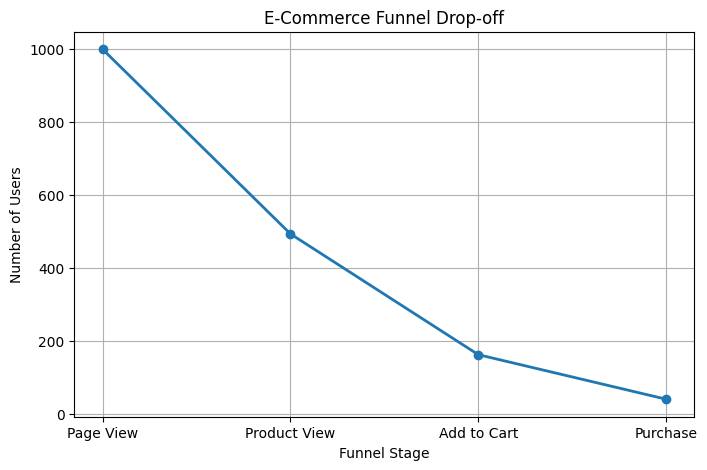

In [20]:
# Funnel Drop-Off Chart
# Set the size of the plot
plt.figure(figsize=(8, 5))

# Plot funnel stages (x-axis) vs number of users (y-axis)
plt.plot(
    funnel_counts1['step'], 
    funnel_counts1['users'], 
    marker='o',
    linewidth=2
)

plt.title('E-Commerce Funnel Drop-off')
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Users')

plt.grid(True)
plt.show()

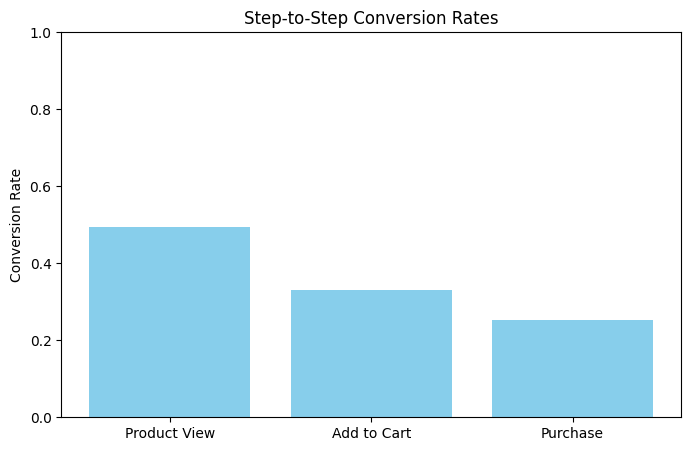

In [21]:
plt.figure(figsize=(8, 5))
plt.bar(
    funnel_counts1['step'][1:], 
    funnel_counts1['conversion_rate'][1:], 
    color='skyblue'
)

plt.title('Step-to-Step Conversion Rates')
plt.ylabel('Conversion Rate')
plt.ylim(0, 1)
plt.show()


In [22]:
# Count how many events each user generated
user_activity = (
    df.groupby('UserID')          # Group events by user
      .size()                     # Count number of events per user
      .reset_index(name='event_count')  
)

# Segment users into two activity levels based on event count distribution
user_activity['activity_segment'] = pd.qcut(
    user_activity['event_count'],  # The metric used for segmentation
    q=2,                           # Split into 2 quantile-based groups (50/50)
    labels=['Low Activity', 'High Activity']  # Labels for the segments
)
user_activity.head()

,UserID,event_count,activity_segment
0,1,82,High Activity
1,2,73,Low Activity
2,3,64,Low Activity
3,4,83,High Activity
4,5,84,High Activity


In [23]:
funnel_segmented = funnel_users.merge(
    user_activity[['UserID', 'activity_segment']],
    on='UserID',
    how='left'
)
funnel_segmented.head()

,UserID,page_view,product_view,add_to_cart,purchase,activity_segment
0,1,True,True,False,False,High Activity
1,2,True,True,False,False,Low Activity
2,3,True,False,False,False,Low Activity
3,4,True,True,False,False,High Activity
4,5,True,False,False,False,High Activity


In [24]:
# Aggregate funnel performance by activity segment
segment_funnel = (
    funnel_segmented
    .groupby('activity_segment', observed=True)[['page_view','product_view','add_to_cart','purchase']]
    .sum()
    .reset_index()
)

segment_funnel


,activity_segment,page_view,product_view,add_to_cart,purchase
0,Low Activity,537,275,94,21
1,High Activity,463,219,69,20


# Segmented Funnel Insight
* High-activity users convert to purchase at a higher rate despite lower overall volume
* Low-activity users contribute more traffic but convert less efficiently. 
* This suggests that increasing early engagement quality may have a stronger impact on conversion than simply increasing traffic.
* Add to cart is the biggest drop-off point for both segments

## Business Implication
* Prioritize improvements at the Add‑to‑Cart stage
* Product efforts should focus on increasing early engagement signals for low-activity users
* Reward and retain High Activity users
* Thes actions are likely to yield higher conversion gains than traffic growth alone.

## Experiment Design Summary
I propose an A/B test targeting users who add items to cart. 
The treatment introduces trust signals during checkout to reduce perceived risk. Success will be measured by an increase in purchase conversion rate, with guardrails to ensure no negative impact on order value or user experience.


In [25]:
experiment_user = funnel_users[funnel_users['add_to_cart']].copy()
experiment_user

,page_view,product_view,add_to_cart,purchase
UserID,,,,
18,True,True,True,False
19,True,True,True,False
33,True,True,True,False
36,True,True,True,False
37,True,True,True,True
...,...,...,...,...
986,True,True,True,False
993,True,True,True,True
994,True,True,True,True


In [26]:
# Randomly assign users to 'control' vs 'Treatement' groups

np.random.seed(42)  # For reproducibility

# Randomly assign each user to either control or treatment group
experiment_user['group'] = np.random.choice(
    ['control', 'treatment'],
    size=len(experiment_user),
    p=[0.5, 0.5]
)

experiment_user.head()


,page_view,product_view,add_to_cart,purchase,group
UserID,,,,,
18,True,True,True,False,control
19,True,True,True,False,treatment
33,True,True,True,False,treatment
36,True,True,True,False,treatment
37,True,True,True,True,control


In [27]:
# Baseline (control) conversion rate
baseline_rate = (
    funnel_users['purchase'].sum() / 
    funnel_users['add_to_cart'].sum()
)

baseline_rate



np.float64(0.25153374233128833)

In [28]:
# +5% lift for treatment group
lift = 0.05  

# Apply lift to treatment group conversion rate
treatment_rate = baseline_rate * (1 + lift)
treatment_rate

np.float64(0.2641104294478528)

In [ ]:
# Simulate purchases outcomes
experiment_user['purchase_simulated'] = np.where(
     # Condition: user is in the control group
    experiment_user['group'] == 'control',
    # Control group: simulate purchases using baseline conversion rate
    np.random.binomial(1, baseline_rate, size=len(experiment_user)),
     # Treatment group: simulate purchases using improved conversion rate
    np.random.binomial(1, treatment_rate, size=len(experiment_user))
)

In [33]:
# Calculate conversion metrics for each experiment group (control vs treatment)
results= (
    experiment_user
    .groupby('group')['purchase_simulated']
    # Aggregate two key metrics:
        # - mean: average of 0/1 values → conversion rate
        # - count: number of users in each group

    .agg(['mean', 'count'])
    .reset_index()
)

results.rename(columns={'mean': 'conversion_rate'}, inplace=True)
results

,group,conversion_rate,count
0,control,0.279070,86
1,treatment,0.311688,77


In [ ]:
# Extract the conversion rate for the control group
# We filter the 'results' table to the row where group == 'control'
# Then select the 'conversion_rate' column and take the first (and only) value

control_rate = results.loc[results['group'] == 'control', 'conversion_rate'].values[0]

# Extract the conversion rate for the treatment group using the same logic
treatment_rate = results.loc[results['group'] == 'treatment', 'conversion_rate'].values[0]

# Calculate the observed lift:
# (difference in conversion rates) / (control conversion rate)
# This gives the relative improvement of treatment over control
lift_observed = (treatment_rate - control_rate) / control_rate
lift_observed


np.float64(0.11688311688311687)

## Experiment Results & Decision
The simulated A/B test showed that the treatment group achieved an approximately 11.7% higher purchase conversion rate compared to the control group. Given the magnitude of the lift and the low-risk nature of the checkout trust signal intervention, the results support shipping the change, pending validation of guardrail metrics in a live experiment.


## Risks, Tradeoffs & Limitations
This analysis is based on simulated experiment outcomes and assumes consistent user behavior across groups. 
While results indicate a strong potential lift in purchase conversion, real-world performance may vary due to user heterogeneity, imperfect randomization, and unobserved behavioral effects. 
Post-launch monitoring of guardrail metrics such as order value, checkout duration, and error rates is recommended to ensure the change delivers sustained value without unintended consequences.
